# Individual household electric power consumption

The scope of this project is to forecast the electric energy consumption for a house in Sceaux (in France, near Paris), between december 2006 and november 2010. The dataset used is available at the *UC Irvine Machine Learning Repository* ([link](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)).

The dataset contains 9 columns:

| Column name | Description |
| --- | ----------- |
| Date | Date in format **dd/mm/yyyy**. |
| Time | Time in format **hh:mm:ss**. |
| Global_active_power | Household global minute-averaged active power (in kilowatt). |
| Global_reactive_power | Household global minute-averaged reactive power (in kilowatt). |
| Voltage | Minute-averaged voltage (in volt). |
| Global_intensity |  Household global minute-averaged current intensity (in ampere). |
| Sub_metering_1 | Energy consumed in the kitchen by a dishwasher, an oven and a microwave (in watt-hour of active energy). |
| Sub_metering_2 | Energy consumed in the laundry room by a washing-machine, a tumble-drier, a refrigerator and a light (in watt-hour of active energy). |
| Sub_metering_3 | Energy consumed by an electric water-heater and an air-conditioner (in watt-hour of active energy). |

Our main target will be the **Global_active_power**, which is the component used by the appliancies.

We see that the dataset does not include any information about the weather, which is generally a good predictor of energy consumption. We can assume that during hot summer days the air conditioning consumption will be higher, and the same will be true for heating in winter days.

The objetive is to create a model that can make predictions about the next 24 hours of **Global_active_power**.

## Import and preprocessing

In [267]:
# import libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime

import warnings
warnings.filterwarnings('ignore')

We set a seed to make results reproducible:

In [268]:
# set seed

tf.random.set_seed(42)
np.random.seed(42)

Now we read the data file:

In [269]:
# import data

data = pd.read_csv('household_power_consumption.txt', sep=';')

Let's give a look at the data:

In [270]:
data.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.860,15.800,0.000,2.000,16.0


In [271]:
data.tail(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075249,26/11/2010,20:53:00,0.944,0.0,238.72,4.0,0.0,0.0,0.0
2075250,26/11/2010,20:54:00,0.946,0.0,239.31,4.0,0.0,0.0,0.0
2075251,26/11/2010,20:55:00,0.946,0.0,239.74,4.0,0.0,0.0,0.0
2075252,26/11/2010,20:56:00,0.942,0.0,239.41,4.0,0.0,0.0,0.0
2075253,26/11/2010,20:57:00,0.946,0.0,240.33,4.0,0.0,0.0,0.0
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


We see that the data are collected every minute, starting on December 16, 2006, at 17:24, and ending on November 11, 2010, at 21:02.

In [272]:
data.shape

(2075259, 9)

The dataset contains over 2 millions rows.

#### Missing values

Now, we can look for missing data:

In [273]:
# missing data

data.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

We have missing values only in one column. We make a more precise analysis:

In [274]:
# check consecutive missing values

na_groups = data['Sub_metering_3'].notna().cumsum()[data['Sub_metering_3'].isna()]
consecutive_na_lengths = na_groups.groupby(na_groups).agg(len).sort_values(ascending=False)

minutes_per_day = 24 * 60

print('Longest consecutive gaps of data (in minutes):')
for n in consecutive_na_lengths.values[0:5]:
    print(f'{n} minutes -> {n//(minutes_per_day)} days and {(n%(minutes_per_day))//60} hours (circa)')

Longest consecutive gaps of data (in minutes):
7226 minutes -> 5 days and 0 hours (circa)
5237 minutes -> 3 days and 15 hours (circa)
3723 minutes -> 2 days and 14 hours (circa)
3305 minutes -> 2 days and 7 hours (circa)
3129 minutes -> 2 days and 4 hours (circa)


Thus we have entire days without data (even a 5 days period)! In this situation, filling missing values seems to be useless. So, we have to remove the column from the dataset: 

In [275]:
# column drop

data = data.drop(columns=['Sub_metering_3'], axis=1)

#### Data conversion

We now look at the types of data:

In [276]:
data.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

Apart from **Date** and **Time**, the other variables are actually numeric. What we can do is to convert them:

In [277]:
# column conversion

numeric_columns = data.columns[2:]

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

We check if the conversion worked:

In [278]:
data.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

#### Data resampling

As we have seen above, the data are sampled every minute. Is it too much for making a good model? Let's look at the graph of the first 24 hours: 

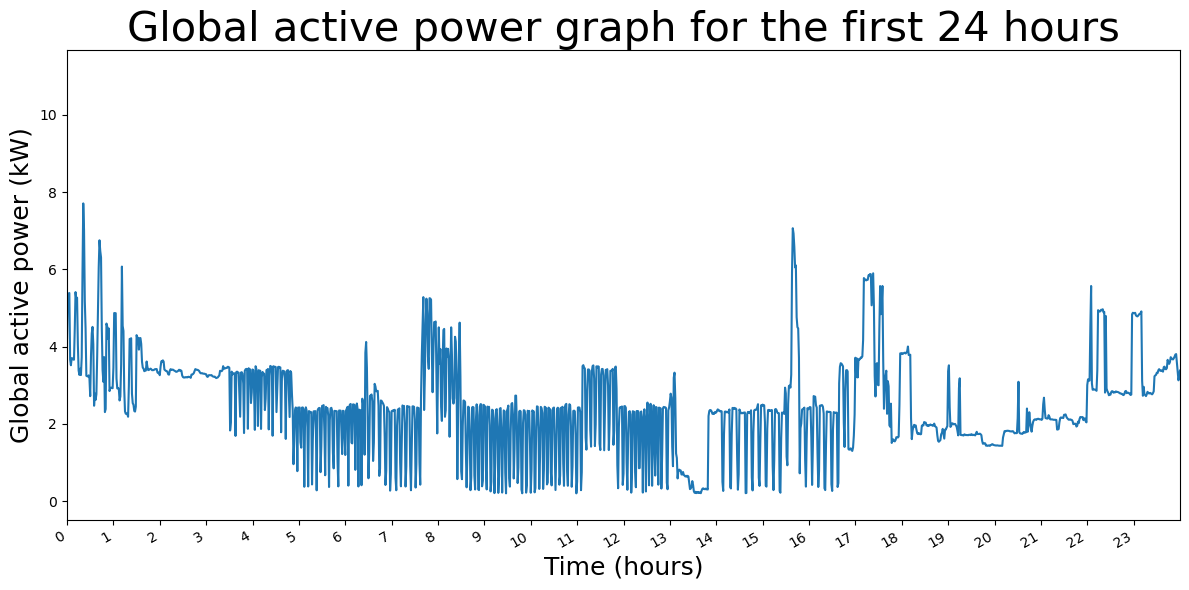

In [279]:
# 24h plot

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data['Global_active_power'])
ax.set_xlabel('Time (hours)', fontsize=18)
ax.set_ylabel('Global active power (kW)', fontsize=18)
ax.set_xlim(0, minutes_per_day)

plt.title('Global active power graph for the first 24 hours', fontsize=30)
plt.xticks(np.arange(0, minutes_per_day, 60), np.arange(0,24))

fig.autofmt_xdate()
plt.tight_layout()

The data are very noisy, as we see oscillations occurring at every minute. So it seems unnecessary to use (and also to forecast) electricity consumption by the minute, also because it is a very short amount of time.

A way to have a more clean and smooth dataset is to resample data by the hour. To do that, we will use the data about date and time. First, we convert them into *datetime* type:

In [280]:
# convert date and time into datetime type (this step will take some time)

data.loc[:, 'datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

data = data.drop(['Date', 'Time'], axis=1)

data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


Now we can resample the data hourly and sum variables within each hour:

In [281]:
# resample data hourly

hourly_data = data.resample('H', on='datetime').sum()

hourly_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0


As we can see, now our data are taken by hour (by summing each minute in the hour). However, there are two rows (the first and the last) that do not have 60 minutes in their sum. So, we have to remove these rows from the dataset:

In [282]:
# remove incomplete hours

hourly_data = hourly_data.drop(hourly_data.head(1).index)
hourly_data = hourly_data.drop(hourly_data.tail(1).index)

In [283]:
# reset index with natural numbers

hourly_data = hourly_data.reset_index()

hourly_data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0


In [284]:
# check shape of data

hourly_data.shape

(34949, 7)

To have a look at the resampled data, we plot the first 15 days of **Global_active_power** (now hourly-averaged):

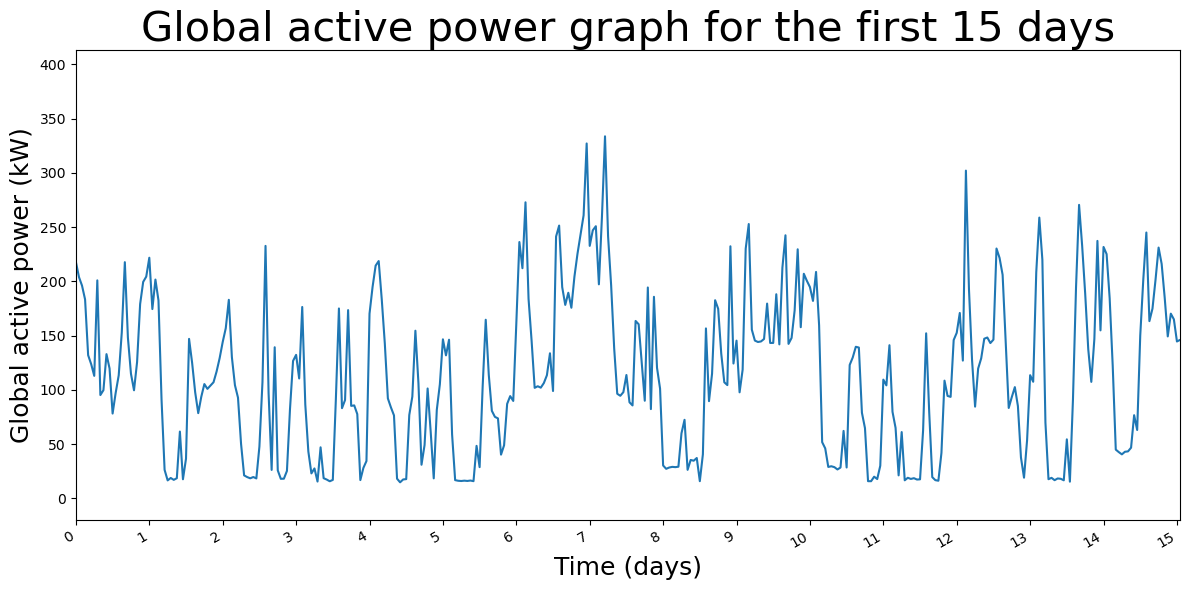

In [285]:
# plot 15 days

hours_in_15_days = 24*15

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(hourly_data['Global_active_power'])
ax.set_xlabel('Time (days)', fontsize=18)
ax.set_ylabel('Global active power (kW)', fontsize=18)
ax.set_xlim(0, hours_in_15_days+1)

plt.title('Global active power graph for the first 15 days', fontsize=30)
plt.xticks(np.arange(0, hours_in_15_days+1, 24), np.arange(0,16))

fig.autofmt_xdate()
plt.tight_layout()

We can save the data after the preprocessing into a CSV file:

In [286]:
hourly_data.to_csv('cleaned_household_power_consumption.csv', header=True, index=False)

## Data analysis and feature engineering

#### Columns statistics and dropping

We start by lookin at some basic statistics for each variable:

In [287]:
# data statistics

hourly_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34949.0,64.002817,54.112103,0.0,19.974,45.868,93.738,393.632
Global_reactive_power,34949.0,7.253838,4.113238,0.0,4.558,6.324,8.884,46.460
Voltage,34949.0,14121.298311,2155.548246,0.0,14340.300,14454.060,14559.180,15114.120
Global_intensity,34949.0,271.331557,226.626113,0.0,88.400,196.600,391.600,1703.000
Sub_metering_1,34949.0,65.785430,210.107036,0.0,0.000,0.000,0.000,2902.000
Sub_metering_2,34949.0,76.139861,248.978569,0.0,0.000,19.000,39.000,2786.000


In [288]:
# non-zero values of Sub_metering_1

non_zero_count = hourly_data[hourly_data['Sub_metering_1']>0]['Sub_metering_1'].count()

zero_percentage = (1 - non_zero_count/len(hourly_data))

zero_percentage

0.8587370167959026

The variable **Sub_metering_1** has a strange behaviour: it is 0 in ~86% of the measurements, and thus it seems useless for predicting the variations of our target variable. So we can remove it from the dataset:

In [289]:
# drop Sub_metering_1 column

hourly_data = hourly_data.drop(['Sub_metering_1'], axis=1)

hourly_data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2
0,2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0
1,2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0
2,2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0
3,2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0
4,2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0


#### Seasonality

Since we are studying the active power in a household, it is very likely that the data will have some sort of seasonality, like day/night and summer/winter. So let's take another look at a plot of the data, say for the first month: 

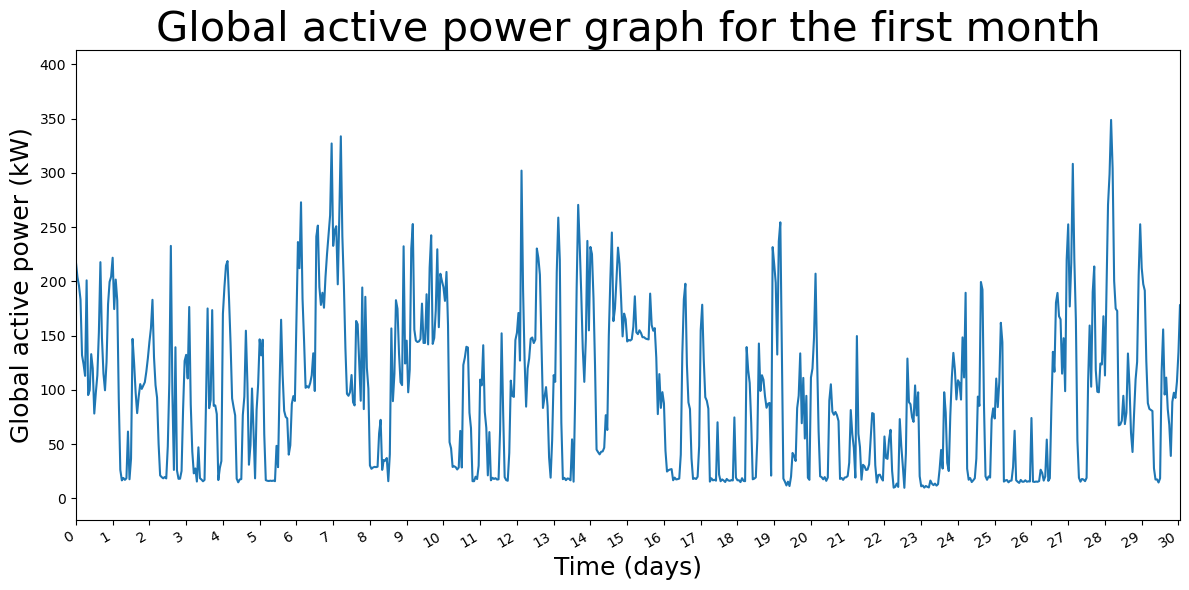

In [290]:
# plot month

hours_in_month = 24*30

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(hourly_data['Global_active_power'])
ax.set_xlabel('Time (days)', fontsize=18)
ax.set_ylabel('Global active power (kW)', fontsize=18)
ax.set_xlim(0, hours_in_month+1)

plt.title('Global active power graph for the first month', fontsize=30)
plt.xticks(np.arange(0, hours_in_month+1, 24), np.arange(0,31))

fig.autofmt_xdate()
plt.tight_layout()

This graph is revealing nothing at all! We can guess a cyclical behaviour, but seasonal periods are not visible. To make us sure there actually is a seasonality, we need to use a *Fourier transformation*, which allow us to visualize frequency and amplitude of a signal (our time series):

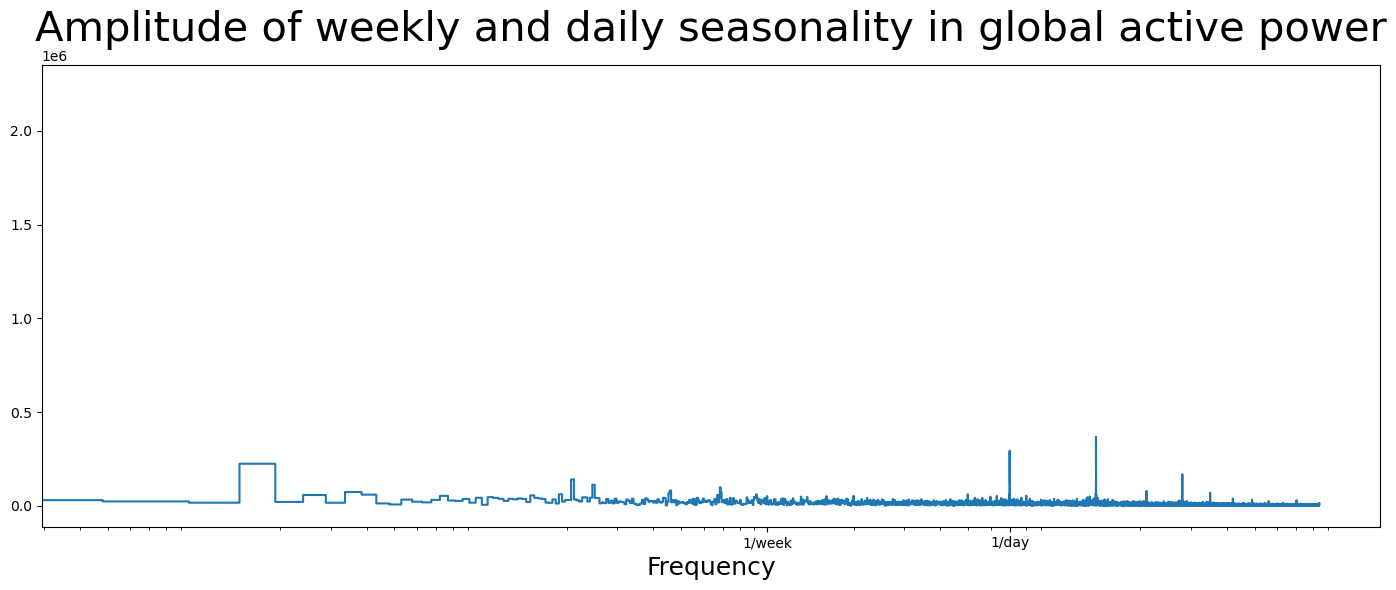

In [291]:
# test for weekly and daily seasonality using Fourier transform

fft = tf.signal.rfft(hourly_data['Global_active_power'])

freq_per_dataset = np.arange(0, len(fft))

n_hours = len(hourly_data['Global_active_power'])

hours_in_week = 24*7
weeks_in_dataset = n_hours / hours_in_week
freq_week = freq_per_dataset / weeks_in_dataset


# plot frequency and amplitude
plt.figure(figsize=(14,6))
plt.step(freq_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency', fontsize=18)
plt.title('Amplitude of weekly and daily seasonality in global active power', fontsize=30)

plt.tight_layout()
plt.show()

From the graph we see that there is no visible peak at weekly level, while there is one at daily level. So we can say that there is a daily seasonality.

What we can do to encode this seasonality is using sine end cosine transformations:

In [292]:
# encode periodicity using sin and cos

timestamp_s = pd.to_datetime(hourly_data['datetime']).map(datetime.datetime.timestamp)

# timestamp is in seconds, so we need seconds in a day
seconds_in_day = 24 * 60 * 60

hourly_data['day_sin'] = np.sin(timestamp_s * (2*np.pi/seconds_in_day)).values
hourly_data['day_cos'] = np.cos(timestamp_s * (2*np.pi/seconds_in_day)).values

# drop datetime column
hourly_data = hourly_data.drop(['datetime'], axis=1)

In [293]:
hourly_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,day_sin,day_cos
0,217.932,4.802,14074.81,936.0,403.0,-0.965926,-2.588190e-01
1,204.014,5.114,13993.95,870.2,86.0,-1.000000,-4.501728e-12
2,196.114,4.506,14044.29,835.0,0.0,-0.965926,2.588190e-01
3,183.388,4.600,14229.52,782.8,25.0,-0.866025,5.000000e-01
4,132.008,3.370,14325.60,571.4,8.0,-0.707107,7.071068e-01


#### Data splitting and scaling

Now the data are ready to be splitted into train, validation and test sets. We use a proportion of 70:20:10:

In [294]:
# split data

n = len(hourly_data)

train_data = hourly_data[:int(n*0.7)]
val_data = hourly_data[int(n*0.7):int(n*0.9)]
test_data = hourly_data[int(n*0.9):]

Then we can scale them:

In [295]:
# scale data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data)

train_data[train_data.columns] = scaler.transform(train_data[train_data.columns])
val_data[val_data.columns] = scaler.transform(val_data[val_data.columns])
test_data[test_data.columns] = scaler.transform(test_data[test_data.columns])

Again, we can save our data:

In [296]:
train_data.to_csv('train.csv', index=False, header=True)
val_data.to_csv('val.csv', index=False, header=True)
test_data.to_csv('test.csv', index=False, header=True)

## Models preparation

We want to build some different models to predict the next 24 hours of active power consumption. The models are:
+ two baseline models
+ a linear model
+ a Deep Learning model
+ a LSTM model
+ a CNN model
+ a combination of LSTM and CNN
+ an autoregressive LSTM model

In [297]:
# import tensorflow libraries

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

Let's set again the seed:

In [298]:
# set seed

tf.random.set_seed(42)
np.random.seed(42)

We will need the indices of the corresponding column names, so we store them:

In [299]:
# get the columns indices

column_indices = {name: i for i, name in enumerate(train_data.columns)}

#### Data windowing

Before initializing the models, we need to create a class for *windowing* our data. This means that we partition the dataset into subsections:

In [300]:
# DataWindow class implementation

class DataWindow():

    def __init__(self, input_width, target_width, shift, train_data=train_data, val_data=val_data, test_data=test_data, target_cols=None) -> None:
        # initialize current dataset (splitted)
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        
        # name of columns to be predicted
        self.target_cols = target_cols
        # create dict with target cols names/indices for plotting
        if target_cols is not None:
            self.target_cols_indices = {name:i for i, name in enumerate(target_cols)}
        # create dict with all cols names/indices
        self.cols_indices = {name:i for i, name in enumerate(train_data.columns)}

        # initialize lengths of window parts
        self.input_width = input_width
        self.target_width = target_width
        self.shift = shift
        self.total_window_size = input_width + shift

        # initialize slice objects to cut the window
        self.input_slice = slice(0, input_width)
        self.target_start = self.total_window_size - self.target_width
        self.target_slice = slice(self.target_start, None)

        # assign indices for plotting
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.target_indices = np.arange(self.total_window_size)[self.target_slice]

    
    # function that make split between inputs and targets
    def split_to_inputs_targets(self, features):
        # features come with shape (batch, time, variables)
        inputs = features[:, self.input_slice, :]
        targets = features[:, self.target_slice, :]
        # stack multiple targets
        if self.target_cols is not None:
            targets = tf.stack(
                [targets[:,:,self.cols_indices[name]] for name in self.target_cols],
                axis=-1
            )
        # specify only time dimension (others will be specified later)
        inputs.set_shape([None, self.input_width, None])
        targets.set_shape([None, self.target_width, None])

        return inputs, targets
    

    # function taht plots inputs, targets and predictions for three time windows
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):

        inputs, targets = self.sample_batch

        plt.figure(figsize=(12,8))
        plot_col_index = self.cols_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

            if self.target_cols:
              target_col_index = self.target_cols_indices.get(plot_col, None)
            else:
              target_col_index = plot_col_index

            if target_col_index is None:
              continue

            plt.scatter(self.target_indices, targets[n, :, target_col_index], edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.target_indices, predictions[n, :, target_col_index], marker='X', edgecolors='k', label='Predictions', c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')


    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_targets)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_data)
    
    @property
    def val(self):
        return self.make_dataset(self.val_data)
    
    @property
    def test(self):
        return self.make_dataset(self.test_data)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result


Together with DataWindow class, we need a function that automates the training process:

In [301]:
# function that trains the models

def compile_and_fit(model, window, patience=3, max_epochs=50):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(),
        metrics=[MeanAbsoluteError()]
    )

    history = model.fit(
        window.train,
        epochs=max_epochs,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

#### Baseline models

Baseline models are useful as a benchmark for other more sophisticated model. Here we initialize two baselines:

In [302]:
# last value baseline

class LastBaseline(Model):
    
    def __init__(self, target_index=None) -> None:
        super().__init__()
        self.target_index = target_index

    def call(self, inputs):
        if self.target_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.target_index:], [1, 24, 1])

In [303]:
# repeat input sequence baseline

class RepeatBaseline(Model):

    def __init__(self, target_index=None) -> None:
        super().__init__()
        self.target_index = target_index

    def call(self, inputs):
        return inputs[:, :, self.target_index:]

## Models predictions

Now we are ready to make predictions using various models.

We start by creating the window we will use:

In [304]:
# 24 hours window

window = DataWindow(
    input_width=24,
    target_width=24,
    shift=24,
    target_cols=['Global_active_power']
)

We then generate predictions using our two baselines and store the performances in a dictionary:

In [305]:
# last value baseline predictions and performance

last_baseline = LastBaseline(target_index=column_indices['Global_active_power'])

last_baseline.compile(
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
    )

#initialize performance dicts
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = last_baseline.evaluate(window.val)
performance['Baseline - Last'] = last_baseline.evaluate(window.test, verbose=0)

217/217 [==============================] - 14s 3ms/step - loss: 0.1788 - mean_absolute_error: 0.3018


In [306]:
# repeated values baseline predictions and performance

repeat_baseline = RepeatBaseline(target_index=column_indices['Global_active_power'])

repeat_baseline.compile(
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
    )

val_performance['Baseline - Repeat'] = repeat_baseline.evaluate(window.val)
performance['Baseline - Repeat'] = repeat_baseline.evaluate(window.test, verbose=0)

217/217 [==============================] - 14s 3ms/step - loss: 0.1828 - mean_absolute_error: 0.3004


Using the plot function in the DataWindow class, we can look at the predictions for the two baselines:

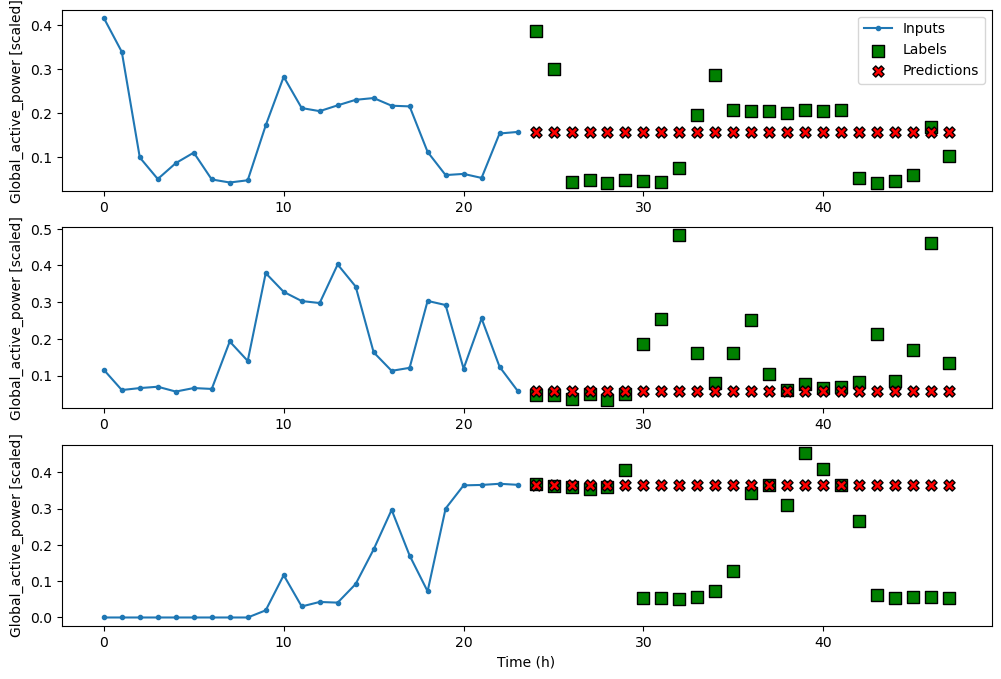

In [307]:
# last value baseline plot

window.plot(last_baseline)

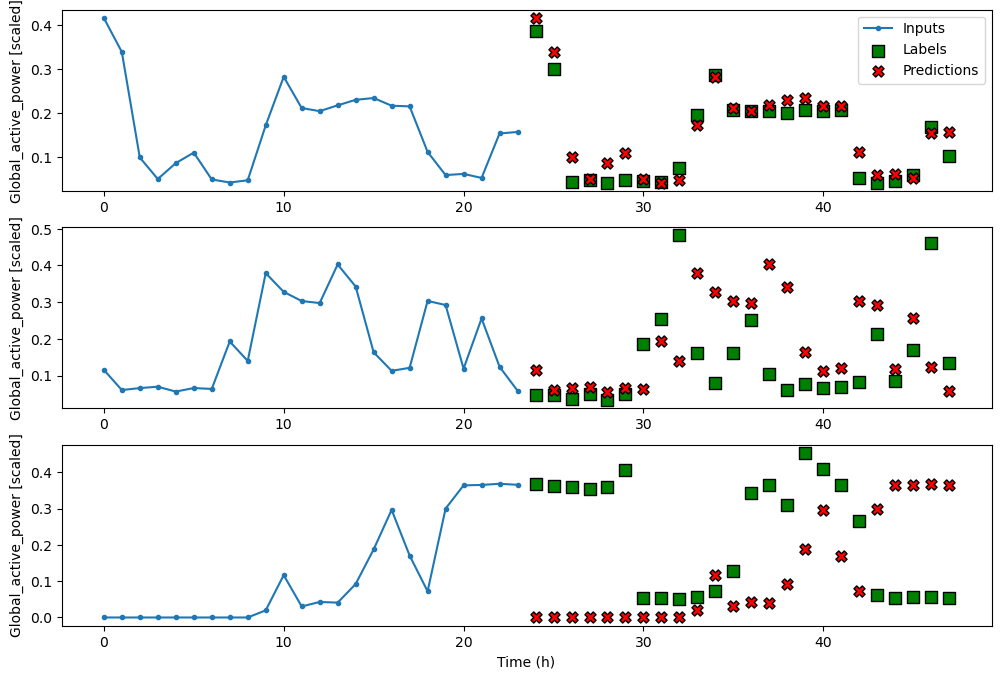

In [308]:
# repeat values baseline plot

window.plot(repeat_baseline)

#### Linear model 

Once we have the starting baseline, we try with different models. First, we use a linear model:

In [309]:
# linear model predictions and performance

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, window)

val_performance['Linear'] = linear.evaluate(window.val)
performance['Linear'] = linear.evaluate(window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 30s 19ms/step - loss: 0.0181 - mean_absolute_error: 0.1035 - val_loss: 0.0143 - val_mean_absolute_error: 0.0923
Epoch 2/50
764/764 [==============================] - 26s 19ms/step - loss: 0.0162 - mean_absolute_error: 0.0977 - val_loss: 0.0142 - val_mean_absolute_error: 0.0913
Epoch 3/50
764/764 [==============================] - 26s 19ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0141 - val_mean_absolute_error: 0.0913
Epoch 4/50
764/764 [==============================] - 26s 17ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0141 - val_mean_absolute_error: 0.0907
Epoch 5/50
764/764 [==============================] - 26s 17ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0141 - val_mean_absolute_error: 0.0902
Epoch 6/50
764/764 [==============================] - 24s 17ms/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0907
Epoc

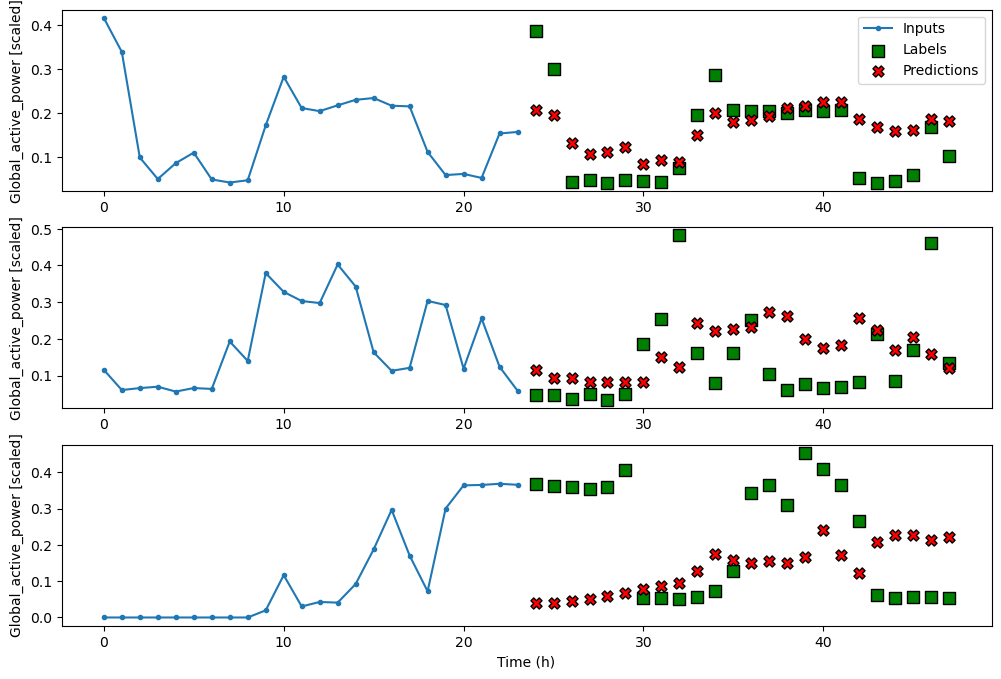

In [310]:
# plot linear model predictions

window.plot(linear)

#### Deep neural network

Next, we try with a model with a hidden layer:

In [311]:
# NN model predictions and performance

dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(dense, window)

val_performance['Dense'] = dense.evaluate(window.val)
performance['Dense'] = dense.evaluate(window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 47s 45ms/step - loss: 0.0155 - mean_absolute_error: 0.0928 - val_loss: 0.0129 - val_mean_absolute_error: 0.0827
Epoch 2/50
764/764 [==============================] - 27s 22ms/step - loss: 0.0147 - mean_absolute_error: 0.0898 - val_loss: 0.0128 - val_mean_absolute_error: 0.0830
Epoch 3/50
764/764 [==============================] - 35s 26ms/step - loss: 0.0147 - mean_absolute_error: 0.0896 - val_loss: 0.0128 - val_mean_absolute_error: 0.0843
Epoch 4/50
764/764 [==============================] - 32s 26ms/step - loss: 0.0146 - mean_absolute_error: 0.0894 - val_loss: 0.0129 - val_mean_absolute_error: 0.0839
Epoch 5/50
764/764 [==============================] - 33s 26ms/step - loss: 0.0146 - mean_absolute_error: 0.0893 - val_loss: 0.0129 - val_mean_absolute_error: 0.0828
Epoch 6/50
217/217 [==============================] - 14s 6ms/step - loss: 0.0129 - mean_absolute_error: 0.0853


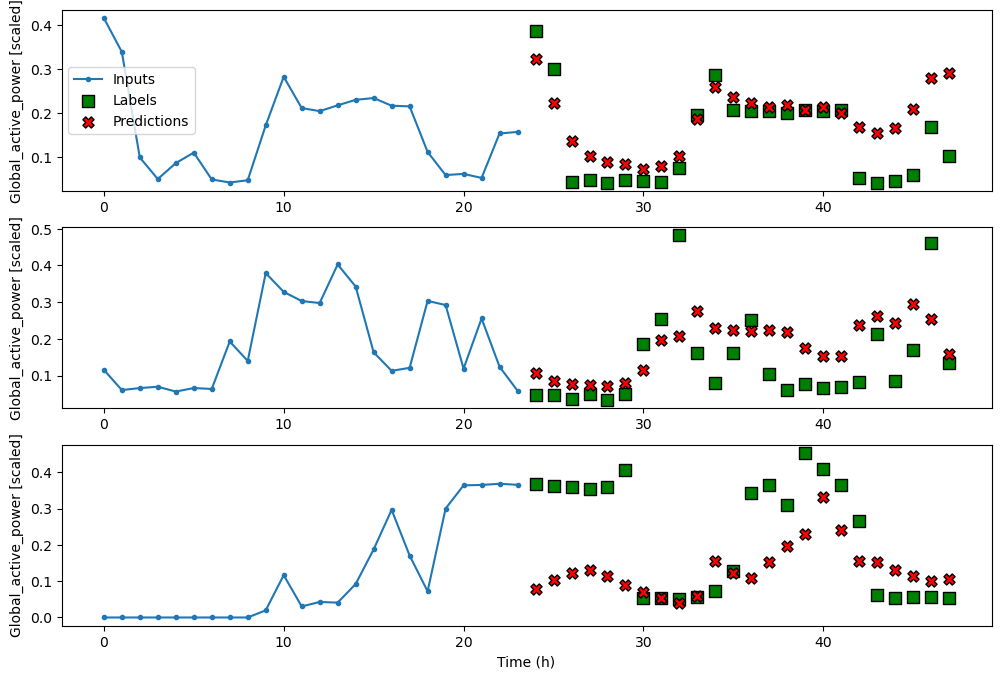

In [312]:
# plot nn model predictions

window.plot(dense)

#### LSTM model

Here we use a *long short-term memory* RNN model:

In [313]:
# LSTM model predictions and performance

lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, window)

val_performance['LSTM'] = lstm_model.evaluate(window.val)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 56s 45ms/step - loss: 0.0167 - mean_absolute_error: 0.0975 - val_loss: 0.0131 - val_mean_absolute_error: 0.0863
Epoch 2/50
764/764 [==============================] - 46s 42ms/step - loss: 0.0148 - mean_absolute_error: 0.0905 - val_loss: 0.0130 - val_mean_absolute_error: 0.0857
Epoch 3/50
764/764 [==============================] - 45s 44ms/step - loss: 0.0145 - mean_absolute_error: 0.0893 - val_loss: 0.0129 - val_mean_absolute_error: 0.0841
Epoch 4/50
764/764 [==============================] - 44s 42ms/step - loss: 0.0144 - mean_absolute_error: 0.0889 - val_loss: 0.0131 - val_mean_absolute_error: 0.0841
Epoch 5/50
764/764 [==============================] - 42s 41ms/step - loss: 0.0144 - mean_absolute_error: 0.0887 - val_loss: 0.0128 - val_mean_absolute_error: 0.0843
Epoch 6/50
764/764 [==============================] - 45s 44ms/step - loss: 0.0144 - mean_absolute_error: 0.0885 - val_loss: 0.0128 - val_mean_absolute_error: 0.0844
Epoc

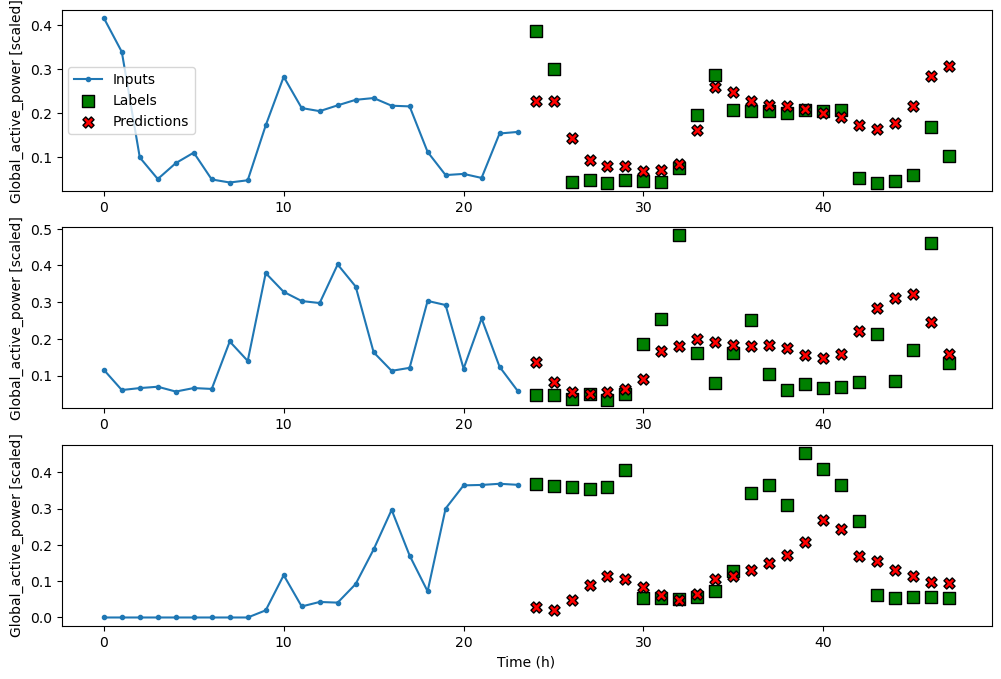

In [314]:
# plot LSTM model predictions

window.plot(lstm_model)

#### CNN model

Now we try with a *convolutional neural network* model. Note that, by the definition of CNNs, we need to change the window accordingly: 

In [315]:
# make a window suitable for CNN

KERNEL_WIDTH = 3
TARGET_WIDTH = 24
INPUT_WIDTH = TARGET_WIDTH + KERNEL_WIDTH - 1

cnn_window = DataWindow(
    input_width=INPUT_WIDTH,
    target_width=TARGET_WIDTH,
    shift=24,
    target_cols=['Global_active_power']
    )

In [316]:
# CNN model predictions and performance

cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 32s 24ms/step - loss: 0.0157 - mean_absolute_error: 0.0937 - val_loss: 0.0129 - val_mean_absolute_error: 0.0833
Epoch 2/50
763/763 [==============================] - 28s 23ms/step - loss: 0.0145 - mean_absolute_error: 0.0891 - val_loss: 0.0127 - val_mean_absolute_error: 0.0836
Epoch 3/50
763/763 [==============================] - 29s 23ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0127 - val_mean_absolute_error: 0.0831
Epoch 4/50
763/763 [==============================] - 29s 23ms/step - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0128 - val_mean_absolute_error: 0.0825
Epoch 5/50
763/763 [==============================] - 28s 23ms/step - loss: 0.0143 - mean_absolute_error: 0.0885 - val_loss: 0.0127 - val_mean_absolute_error: 0.0828
Epoch 6/50
763/763 [==============================] - 29s 22ms/step - loss: 0.0143 - mean_absolute_error: 0.0883 - val_loss: 0.0127 - val_mean_absolute_error: 0.0833
Epoc

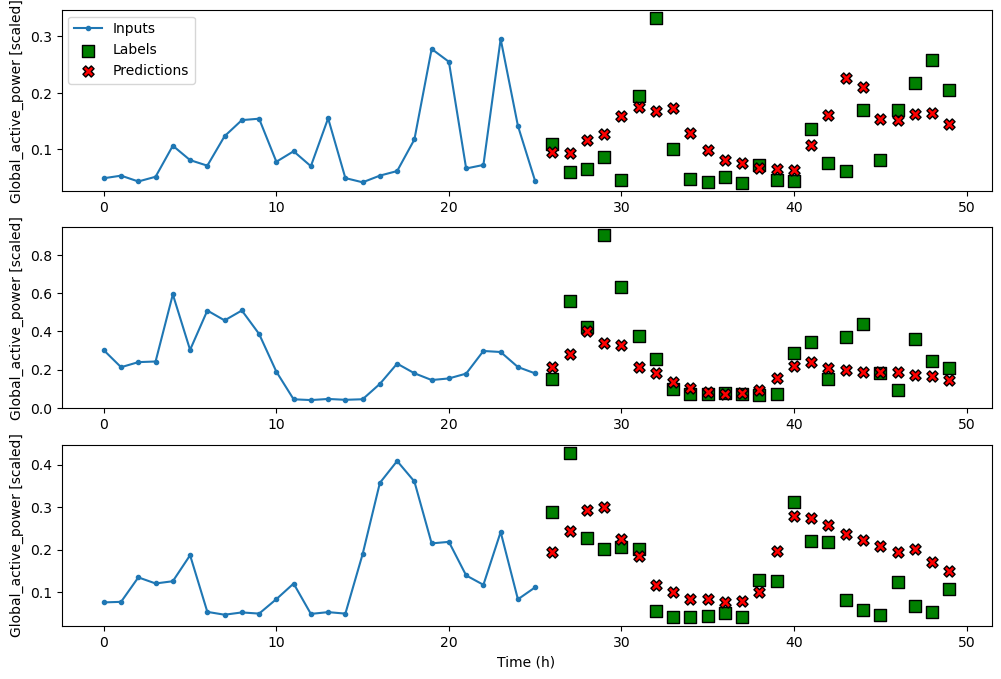

In [317]:
# CNN model predictions plot

cnn_window.plot(cnn_model)

#### CNN and LSTM combination model

We can also put together LSTM and CNN models and see if they perform better:

In [318]:
# CNN+LSTM model predictions and performance

cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 53s 47ms/step - loss: 0.0160 - mean_absolute_error: 0.0950 - val_loss: 0.0130 - val_mean_absolute_error: 0.0851
Epoch 2/50
763/763 [==============================] - 47s 47ms/step - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0128 - val_mean_absolute_error: 0.0835
Epoch 3/50
763/763 [==============================] - 47s 48ms/step - loss: 0.0142 - mean_absolute_error: 0.0879 - val_loss: 0.0128 - val_mean_absolute_error: 0.0839
Epoch 4/50
763/763 [==============================] - 47s 47ms/step - loss: 0.0142 - mean_absolute_error: 0.0878 - val_loss: 0.0127 - val_mean_absolute_error: 0.0836
Epoch 5/50
763/763 [==============================] - 47s 46ms/step - loss: 0.0141 - mean_absolute_error: 0.0875 - val_loss: 0.0127 - val_mean_absolute_error: 0.0839
Epoch 6/50
763/763 [==============================] - 55s 56ms/step - loss: 0.0141 - mean_absolute_error: 0.0874 - val_loss: 0.0129 - val_mean_absolute_error: 0.0834
Epoc

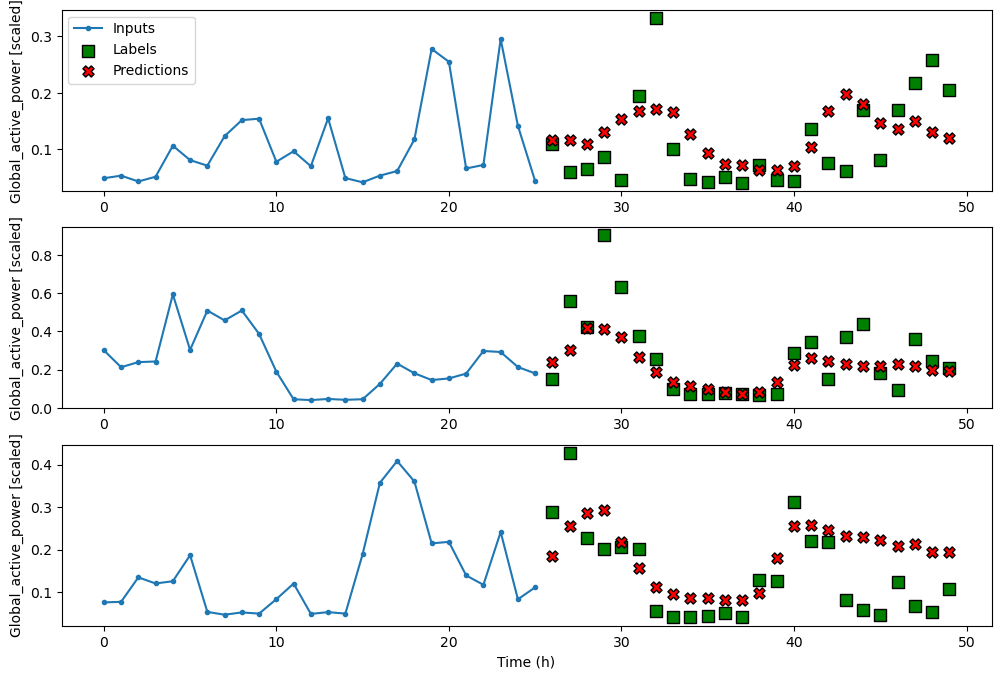

In [319]:
# CNN+LSTM model predictions plot

cnn_window.plot(cnn_lstm_model)

#### Autoregressive model

The last model we want to try is and *autoregressive LSTM* model, which instead of generating the entire output in one shot, predicts a single timestamp and use it as an input for other predictions:

In [320]:
# class definition for an autoregressive LSTM model

class AutoRegressive(Model):
    
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_data.shape[1])
        

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [321]:
# AR-LSTM model predictions and performance

autoreg_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(autoreg_LSTM, window)

val_performance['AR - LSTM'] = autoreg_LSTM.evaluate(window.val)
performance['AR - LSTM'] = autoreg_LSTM.evaluate(window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 66s 58ms/step - loss: 0.0183 - mean_absolute_error: 0.1063 - val_loss: 0.0138 - val_mean_absolute_error: 0.0906
Epoch 2/50
764/764 [==============================] - 57s 56ms/step - loss: 0.0146 - mean_absolute_error: 0.0901 - val_loss: 0.0126 - val_mean_absolute_error: 0.0840
Epoch 3/50
764/764 [==============================] - 61s 65ms/step - loss: 0.0140 - mean_absolute_error: 0.0875 - val_loss: 0.0126 - val_mean_absolute_error: 0.0830
Epoch 4/50
764/764 [==============================] - 53s 54ms/step - loss: 0.0139 - mean_absolute_error: 0.0868 - val_loss: 0.0121 - val_mean_absolute_error: 0.0817
Epoch 5/50
764/764 [==============================] - 53s 55ms/step - loss: 0.0138 - mean_absolute_error: 0.0863 - val_loss: 0.0121 - val_mean_absolute_error: 0.0814
Epoch 6/50
764/764 [==============================] - 54s 56ms/step - loss: 0.0137 - mean_absolute_error: 0.0859 - val_loss: 0.0122 - val_mean_absolute_error: 0.0818
Epoc

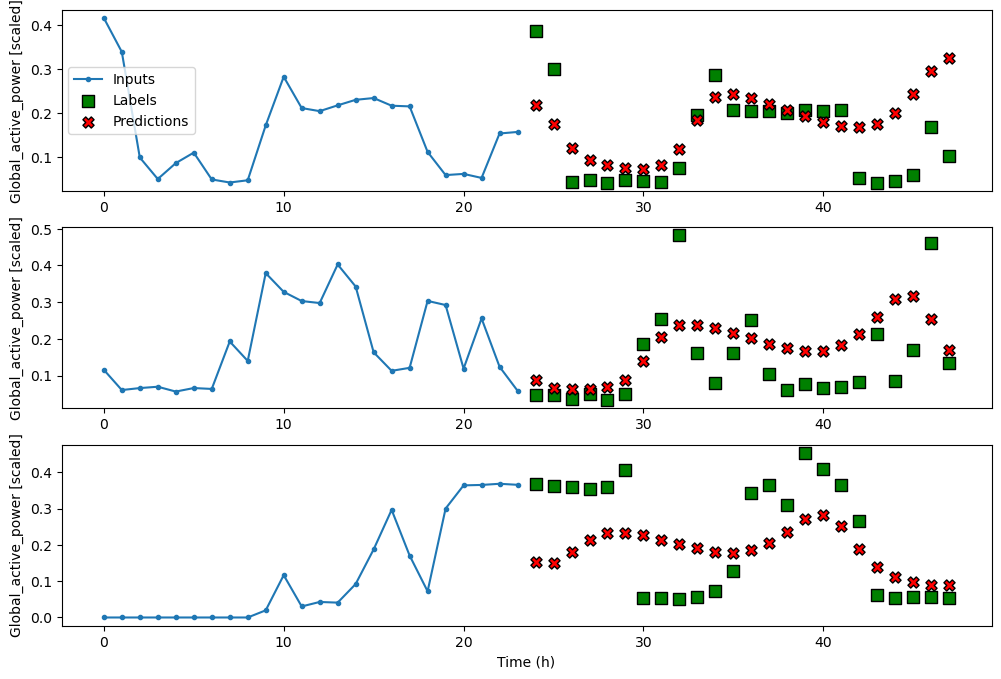

In [322]:
# AR-LSTM model predictions plot

window.plot(autoreg_LSTM)

## Best model selection

We are now at the final act of our project. We have trained several models, and used them to make predictions. Now it is time to see which one have performed better. So it is sufficient to make a graph of the performances:

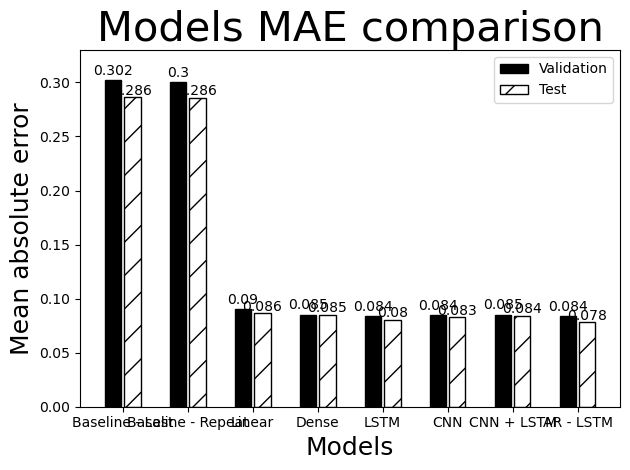

In [323]:
# bar plot of MAEs

mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error', fontsize=18)
ax.set_xlabel('Models', fontsize=18)


for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.title('Models MAE comparison', fontsize=30)
plt.legend(loc='best')
plt.tight_layout()

The best model is the Autoregressive LSTM, and so it is the one that should be use to forecast future electricity power consumption.